<a href="https://colab.research.google.com/github/spandanbhandari/LLMs-from-Scratch/blob/main/InstructionFineTuning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import json
import os
import urllib
def download_and_load_file(file_path, url):
    if not os.path.exists(file_path):
        with urllib.request.urlopen(url) as response:
            text_data = response.read().decode("utf-8")
        with open(file_path, "w", encoding="utf-8") as file:
            file.write(text_data)
    else:                                                #1
        with open(file_path, "r", encoding="utf-8") as file:
            text_data = file.read()
    with open(file_path, "r") as file:
        data = json.load(file)
    return data
file_path = "instruction-data.json"
url = (
    "https://raw.githubusercontent.com/rasbt/LLMs-from-scratch"
    "/main/ch07/01_main-chapter-code/instruction-data.json"
 )
data = download_and_load_file(file_path, url)
print("Number of entries:", len(data))

Number of entries: 1100


In [ ]:
print("Example Entry:\n",data[50])

Example Entry:
 {'instruction': 'Identify the correct spelling of the following word.', 'input': 'Ocassion', 'output': "The correct spelling is 'Occasion.'"}


In [ ]:
def format_input(entry):
  instruction_text=(
      f"Below is an instruction that describes a task."
      f"Write a response that appropriately completes the request."
      f"\n\n### Instruction:\n{entry['instruction']}"
  )
  input_text=(
      f"\n\n### Input:\n{entry['input']}"
      if entry["input"]  else ""
  )
  return instruction_text+input_text

In [ ]:
model_input=format_input(data[50])
desired_response=f"\n\n### Response:\n{data[50]['output']}"
print(model_input+desired_response)

Below is an instruction that describes a task.Write a response that appropriately completes the request.

### Instruction:
Identify the correct spelling of the following word.

### Input:
Ocassion

### Response:
The correct spelling is 'Occasion.'


In [ ]:
model_input=format_input(data[999])
desired_response=f"\n\n### Response:\n{data[999]['output']}"
print(model_input+desired_response)

Below is an instruction that describes a task.Write a response that appropriately completes the request.

### Instruction:
What is an antonym of 'complicated'?

### Response:
An antonym of 'complicated' is 'simple'.


In [ ]:
train_portion=int(len(data)*0.85)
test_portion=int(len(data)*0.1)
val_portion=len(data)-train_portion-test_portion

train_data=data[:train_portion]
test_data=data[train_portion:train_portion+test_portion]
val_data=data[train_portion+test_portion:]

print("Number of training examples:", len(train_data))
print("Number of testing examples:", len(test_data))
print("Number of validation examples:", len(val_data))

Number of training examples: 935
Number of testing examples: 110
Number of validation examples: 55


In [ ]:
import torch
from torch.utils.data import Dataset

class InstructionDataset(Dataset):
    def __init__(self, data, tokenizer):
        self.data = data
        self.encoded_texts=[]
        for entry in data:
          instruction_plus_input=format_input(entry)
          response_text=f"\n\n### Response:\n{entry['output']}"
          full_text=instruction_plus_input+response_text
          self.encoded_texts.append(tokenizer.encode(full_text))
    def __getitem__(self, index):
      return self.encoded_texts[index]
    def __len__(self):
      return len(self.data)

In [ ]:
pip install tiktoken

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 MB 45.6 MB/s eta 0:00:00


In [ ]:
import tiktoken
tokenizer=tiktoken.get_encoding("gpt2")
print(tokenizer.encode("<|endoftext|>",allowed_special={"<|endoftext|>"}))

[50256]


In [ ]:
def custom_collate_draft_1(
    batch,
    pad_token_id=50256,
    device="cpu"
):
  batch_max_length=max(len(item)+1 for item in batch)
  inputs_lst=[]

  for item in batch:
    new_item=item.copy()
    new_item+=[pad_token_id]

    padded=(
        new_item+[pad_token_id]*(batch_max_length-len(new_item))
    )
    inputs=torch.tensor(padded[:-1])
    inputs_lst.append(inputs)

  inputs_tensor=torch.stack(inputs_lst).to(device)
  return inputs_tensor

In [ ]:
inputs_1 = [0, 1, 2, 3, 4]
inputs_2 = [5, 6]
inputs_3 = [7, 8, 9]
batch = (
    inputs_1,
    inputs_2,
    inputs_3
 )
print(custom_collate_draft_1(batch))

tensor([[    0,     1,     2,     3,     4],
        [    5,     6, 50256, 50256, 50256],
        [    7,     8,     9, 50256, 50256]])


In [ ]:
def custom_collate_draft_2(
    batch,
    pad_token_id=50256,
    device="cpu"
):
  batch_max_length=max(len(item)+1 for item in batch)
  inputs_lst,targets_lst=[],[]
  for item in batch:
    new_item=item.copy()
    new_item+=[pad_token_id]
    padded=(
        new_item+[pad_token_id]*(batch_max_length-len(new_item))
    )
    inputs=torch.tensor(padded[:-1])
    targets=torch.tensor(padded[1:])
    inputs_lst.append(inputs)
    targets_lst.append(targets)
  inputs_tensor=torch.stack(inputs_lst).to(device)
  targets_tensor=torch.stack(targets_lst).to(device)
  return inputs_tensor,targets_tensor
inputs,targets=custom_collate_draft_2(batch)
print(inputs)
print(targets)

tensor([[    0,     1,     2,     3,     4],
        [    5,     6, 50256, 50256, 50256],
        [    7,     8,     9, 50256, 50256]])
tensor([[    1,     2,     3,     4, 50256],
        [    6, 50256, 50256, 50256, 50256],
        [    8,     9, 50256, 50256, 50256]])


In [ ]:
def custom_collate_fn(
    batch,
    pad_token_id=50256,
    ignore_index=-100,
    allowed_max_length=None,
    device="cpu"
):
  batch_max_length=max(len(item)+1 for item in batch)
  inputs_lst,targets_lst=[],[]

  for item in batch:
    new_item=item.copy()
    new_item+=[pad_token_id]

    padded=(
        new_item+[pad_token_id]*(batch_max_length-len(new_item))
    )
    inputs=torch.tensor(padded[:-1])
    targets=torch.tensor(padded[1:])

    mask=targets==pad_token_id
    indices=torch.nonzero(mask).squeeze()
    if indices.numel()>1:
      targets[indices[1:]]=ignore_index
    if allowed_max_length is not None:
      inputs=inputs[:allowed_max_length]
      targets=targets[:allowed_max_length]
    inputs_lst.append(inputs)
    targets_lst.append(targets)
  inputs_tensor=torch.stack(inputs_lst).to(device)
  targets_tensor=torch.stack(targets_lst).to(device)
  return inputs_tensor,targets_tensor

In [ ]:
inputs,targets=custom_collate_fn(batch)
print(inputs)
print(targets)

tensor([[    0,     1,     2,     3,     4],
        [    5,     6, 50256, 50256, 50256],
        [    7,     8,     9, 50256, 50256]])
tensor([[    1,     2,     3,     4, 50256],
        [    6, 50256,  -100,  -100,  -100],
        [    8,     9, 50256,  -100,  -100]])


In [ ]:
device=torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device:",device)

Device: cuda


In [ ]:
from functools import partial

customized_collate_fn=partial(
    custom_collate_fn,
    device=device,
    allowed_max_length=1024
)

In [ ]:
from torch.utils.data import DataLoader

num_workers=0
batch_size=8

torch.manual_seed(123)
train_dataset=InstructionDataset(train_data,tokenizer)
train_loader=DataLoader(
    train_dataset,
    batch_size=batch_size,
    collate_fn=customized_collate_fn,
    shuffle=True,
    num_workers=num_workers
)
val_dataset=InstructionDataset(val_data,tokenizer)
val_loader=DataLoader(
    val_dataset,
    batch_size=batch_size,
    collate_fn=customized_collate_fn,
    shuffle=False,
    drop_last=False,
    num_workers=num_workers
)
test_dataset=InstructionDataset(test_data,tokenizer)
test_loader=DataLoader(
    test_dataset,
    batch_size=batch_size,
    collate_fn=customized_collate_fn,
    shuffle=False,
    drop_last=False,
    num_workers=num_workers
)

In [ ]:
print("Train Loader:")
for inputs,targets in train_loader:
  print(inputs.shape,targets.shape)

Train Loader:
torch.Size([8, 61]) torch.Size([8, 61])
torch.Size([8, 76]) torch.Size([8, 76])
torch.Size([8, 73]) torch.Size([8, 73])
torch.Size([8, 68]) torch.Size([8, 68])
torch.Size([8, 65]) torch.Size([8, 65])
torch.Size([8, 72]) torch.Size([8, 72])
torch.Size([8, 80]) torch.Size([8, 80])
torch.Size([8, 67]) torch.Size([8, 67])
torch.Size([8, 62]) torch.Size([8, 62])
torch.Size([8, 75]) torch.Size([8, 75])
torch.Size([8, 62]) torch.Size([8, 62])
torch.Size([8, 68]) torch.Size([8, 68])
torch.Size([8, 67]) torch.Size([8, 67])
torch.Size([8, 77]) torch.Size([8, 77])
torch.Size([8, 69]) torch.Size([8, 69])
torch.Size([8, 79]) torch.Size([8, 79])
torch.Size([8, 71]) torch.Size([8, 71])
torch.Size([8, 66]) torch.Size([8, 66])
torch.Size([8, 83]) torch.Size([8, 83])
torch.Size([8, 68]) torch.Size([8, 68])
torch.Size([8, 80]) torch.Size([8, 80])
torch.Size([8, 71]) torch.Size([8, 71])
torch.Size([8, 69]) torch.Size([8, 69])
torch.Size([8, 65]) torch.Size([8, 65])
torch.Size([8, 68]) torch.

In [ ]:
pip install llms-from-scratch

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 47.1/47.1 kB 3.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.3/12.3 MB 119.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.8/1.8 MB 70.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 3.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 82.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 73.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 57.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 13.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 8.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.

In [ ]:
from llms_from_scratch.ch05 import download_and_load_gpt2
from llms_from_scratch.ch04 import GPTModel
from llms_from_scratch.ch05 import load_weights_into_gpt

BASE_CONFIG = {
    "vocab_size": 50257,     # Vocabulary size
    "context_length": 1024,  # Context length
    "drop_rate": 0.0,        # Dropout rate
    "qkv_bias": True         # Query-key-value bias
 }
model_configs = {
    "gpt2-small (124M)": {"emb_dim": 768, "n_layers": 12, "n_heads": 12},
    "gpt2-medium (355M)": {"emb_dim": 1024, "n_layers": 24, "n_heads": 16},
    "gpt2-large (774M)": {"emb_dim": 1280, "n_layers": 36, "n_heads": 20},
    "gpt2-xl (1558M)": {"emb_dim": 1600, "n_layers": 48, "n_heads": 25},
 }
CHOOSE_MODEL = "gpt2-medium (355M)"
BASE_CONFIG.update(model_configs[CHOOSE_MODEL])
model_size = CHOOSE_MODEL.split(" ")[-1].lstrip("(").rstrip(")")
settings, params = download_and_load_gpt2(
    model_size=model_size,
    models_dir="gpt2"
 )
model = GPTModel(BASE_CONFIG)
load_weights_into_gpt(model, params)
model.eval();


checkpoint: 100%|██████████| 77.0/77.0 [00:00<00:00, 113kiB/s]
encoder.json: 100%|██████████| 1.04M/1.04M [00:01<00:00, 523kiB/s]
hparams.json: 100%|██████████| 91.0/91.0 [00:00<00:00, 141kiB/s]
model.ckpt.data-00000-of-00001: 100%|██████████| 1.42G/1.42G [07:23<00:00, 3.20MiB/s]
model.ckpt.index: 100%|██████████| 10.4k/10.4k [00:00<00:00, 12.5MiB/s]
model.ckpt.meta: 100%|██████████| 927k/927k [00:01<00:00, 581kiB/s]
vocab.bpe: 100%|██████████| 456k/456k [00:01<00:00, 327kiB/s]


In [ ]:
torch.manual_seed(123)
input_text=format_input(val_data[0])
print(input_text)

Below is an instruction that describes a task.Write a response that appropriately completes the request.

### Instruction:
Convert the active sentence to passive: 'The chef cooks the meal every day.'


In [ ]:
from llms_from_scratch.ch05 import generate,text_to_token_ids,token_ids_to_text
token_ids=generate(
    model=model,
    idx=text_to_token_ids(input_text,tokenizer),
    max_new_tokens=35,
    context_size=BASE_CONFIG["context_length"],
    eos_id=50256,
)
generated_text=token_ids_to_text(token_ids,tokenizer)
print(generated_text)

Below is an instruction that describes a task.Write a response that appropriately completes the request.

### Instruction:
Convert the active sentence to passive: 'The chef cooks the meal every day.'

### Instruction:

Convert the active sentence to passive: 'The chef cooks the meal every day.'

### Instruction:

Convert the active


In [ ]:
response_text=generated_text[len(input_text):].strip()
print(response_text)

### Instruction:

Convert the active sentence to passive: 'The chef cooks the meal every day.'

### Instruction:

Convert the active


In [ ]:
from llms_from_scratch.ch05 import (
    calc_loss_loader,
    train_model_simple
)

In [ ]:
model.to(device)
torch.manual_seed(123)
with torch.no_grad():
  train_loss=calc_loss_loader(
      train_loader,model,device,num_batches=5
  )
  val_loss=calc_loss_loader(
      val_loader,model,device,num_batches=5
  )
print(f"Train Loss: {train_loss:.4f}")
print(f"Validation Loss: {val_loss:.4f}")

Train Loss: 4.0136
Validation Loss: 3.9385


In [ ]:
import time

start_time=time.time()
torch.manual_seed(123)
optimizer=torch.optim.AdamW(
    model.parameters(),lr=0.00005,weight_decay=0.1
)
num_epochs=2
train_losses,val_losses,tokens_seen=train_model_simple(
    model,train_loader,val_loader,optimizer,device,num_epochs=num_epochs,eval_freq=5,eval_iter=5,start_context=format_input(val_data[0]),tokenizer=tokenizer
)
end_time=time.time()
execution_time_minutes=(end_time-start_time)/60
print(f"Execution Time: {execution_time_minutes:.2f} minutes")

Ep 1 (Step 000000): Train loss 2.776, Val loss 2.755
Ep 1 (Step 000005): Train loss 1.207, Val loss 1.138
Ep 1 (Step 000010): Train loss 0.872, Val loss 0.968
Ep 1 (Step 000015): Train loss 0.856, Val loss 0.907
Ep 1 (Step 000020): Train loss 0.788, Val loss 0.910
Ep 1 (Step 000025): Train loss 0.774, Val loss 0.866
Ep 1 (Step 000030): Train loss 0.801, Val loss 0.841
Ep 1 (Step 000035): Train loss 0.716, Val loss 0.812
Ep 1 (Step 000040): Train loss 0.669, Val loss 0.801
Ep 1 (Step 000045): Train loss 0.633, Val loss 0.790
Ep 1 (Step 000050): Train loss 0.663, Val loss 0.783
Ep 1 (Step 000055): Train loss 0.763, Val loss 0.771
Ep 1 (Step 000060): Train loss 0.720, Val loss 0.748
Ep 1 (Step 000065): Train loss 0.651, Val loss 0.739
Ep 1 (Step 000070): Train loss 0.530, Val loss 0.732
Ep 1 (Step 000075): Train loss 0.566, Val loss 0.731
Ep 1 (Step 000080): Train loss 0.603, Val loss 0.724
Ep 1 (Step 000085): Train loss 0.511, Val loss 0.706
Ep 1 (Step 000090): Train loss 0.564, Val loss

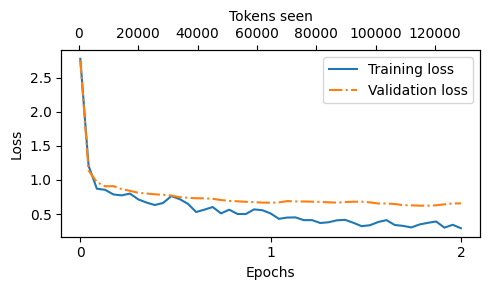

In [ ]:
from llms_from_scratch.ch05 import plot_losses
epochs_tensor=torch.linspace(0,num_epochs,len(train_losses))
plot_losses(epochs_tensor,tokens_seen,train_losses,val_losses)

In [ ]:
torch.manual_seed(123)

for entry in test_data[:3]:
  input_text=format_input(entry)
  token_ids=generate(
      model=model,
      idx=text_to_token_ids(input_text,tokenizer).to(device),
      max_new_tokens=256,
      context_size=BASE_CONFIG["context_length"],
      eos_id=50256,
  )
  generated_text=token_ids_to_text(token_ids,tokenizer)
  response_text=(
      generated_text[len(input_text):].replace('### Response:',"").strip()
  )
  print(input_text)
  print(f"\nCorrect response:\n>> {entry['output']}")
  print(f"Generated response:\n>> {response_text.strip()}")

Below is an instruction that describes a task.Write a response that appropriately completes the request.

### Instruction:
Rewrite the sentence using a simile.

### Input:
The car is very fast.

Correct response:
>> The car is as fast as lightning.
Generated response:
>> The car is as fast as a bullet.
Below is an instruction that describes a task.Write a response that appropriately completes the request.

### Instruction:
What type of cloud is typically associated with thunderstorms?

Correct response:
>> The type of cloud typically associated with thunderstorms is cumulonimbus.
Generated response:
>> The type of cloud associated with thunderstorms is a cumulus cloud.
Below is an instruction that describes a task.Write a response that appropriately completes the request.

### Instruction:
Name the author of 'Pride and Prejudice'.

Correct response:
>> Jane Austen.
Generated response:
>> The author of 'Pride and Prejudice' is Jane Austen.


In [ ]:
from tqdm import tqdm
for i,entry in tqdm(enumerate(test_data),total=len(test_data)):
  input_text=format_input(entry)
  token_ids=generate(
      model=model,
      idx=text_to_token_ids(input_text,tokenizer).to(device),
      max_new_tokens=256,
      context_size=BASE_CONFIG["context_length"],
      eos_id=50256
  )
  generated_text=token_ids_to_text(token_ids,tokenizer)
  response_text=(
      generated_text[len(input_text):].replace('### Response:',"").strip()
  )
  test_data[i]["model_response"]=response_text
with open("instruction-data-with-response.json","w") as file:
  json.dump(test_data,file,indent=4)

100%|██████████| 110/110 [01:10<00:00,  1.57it/s]


In [ ]:
print(test_data[0])

{'instruction': 'Rewrite the sentence using a simile.', 'input': 'The car is very fast.', 'output': 'The car is as fast as lightning.', 'model_response': 'The car is as fast as a bullet.'}


In [ ]:
import re
file_name = f"{re.sub(r'[ ()]', '', CHOOSE_MODEL) }-sft.pth"
torch.save(model.state_dict(), file_name)
print(f"Model saved as {file_name}")

Model saved as gpt2-medium355M-sft.pth
